# Predicting Bike Rentals
Bike sharing stations are being much more common across the US where you can rent bicycles by the hour or day. Washington, D.C. has a station and collects detailed data on the number of bicycles people rent. 

In this project we will try to predict the total number of bikes people rented in a given hour using different machine learning models.
## Data Exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
%matplotlib inline

In [3]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


The columns in the dataframe are

- instant: A unique sequential ID number for each row
- dteday: The date of the rentals
- season: The season in wich the rentals ocurred
- yr: The year the rentals ocurred
- mnth: The month the rentals ocurred
- hr: The hour the rentals occurred
- holiday: Whether or not the day was a holiday
- weekday: The day of the week, as a number from 0 to 7
- workingday: Whether or not the day was a working day
- weathersit: The weather (as a categorical variable)
- temp: The temperature, on a 0-1 scale
- atemp: The adjusted temperature
- hum: The humidity on a 0-1 scale
- windspeed: The wind speed, on a 0-1 scale
- casual: The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered: The number of registered riders (people who had already signed up)
- cnt: The total number of bike rentals (casual + registered)

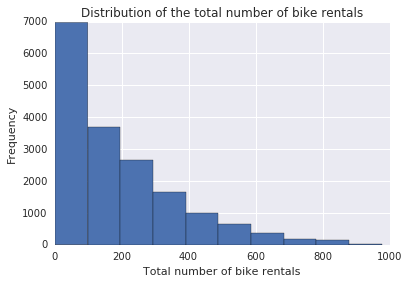

In [5]:
plt.hist(bike_rentals['cnt'])
plt.title('Distribution of the total number of bike rentals')
plt.xlabel('Total number of bike rentals')
plt.ylabel('Frequency')
plt.show()

Notice that the data is skewed right and that nearly 7,000 data entries have between 0 and 100 bike rentals. 

In [6]:
bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

It appears atemp, temp, hr, casual, and registered have strong correlations with the cnt column. On the other hand, holiday, weathersit, and hum have negative correlations with the cnt column.

In [7]:
bike_rentals.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

The dataset is already cleaned and we don't have any NaN data. However if we use the data as is in a model, the accuracy or the error score will be high due to the nature of the hr column. A mode would not understand that certain hours are related, so we can create a new column with labels for morning, afteroon, evening, and night as follows:

- from 6 to 12: 1 (morning)
- from 12 to 18: 2 (afternoon)
- from 18 to 24: 3 (evening)
- from 0 to 6: 4 (night)

In [8]:
def assign_label(row):
    if row >= 6 and row < 12:
        label = 1
    elif row >= 12 and row < 18:
        label = 2
    elif row >= 18 and row < 24:
        label = 3
    elif row >= 0 and row < 6:
        label = 4
    return label

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


## Error Metric
The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well.

In [10]:
train = bike_rentals.sample(frac=.8)

In [11]:
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [12]:
predictors = list(train.columns)
predictors.remove("cnt")
predictors.remove("casual")
predictors.remove("registered")
predictors.remove("dteday")

reg = LinearRegression()

reg.fit(train[predictors], train["cnt"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
predictions = reg.predict(test[predictors])

np.mean((predictions - test["cnt"]) ** 2)

17299.881963888532

## Error
The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

In [15]:
reg = DecisionTreeRegressor(min_samples_leaf=5)

reg.fit(train[predictors], train["cnt"])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [17]:
predictions = reg.predict(test[predictors])

np.mean((predictions - test["cnt"]) ** 2)

2509.036446731761

In [18]:
reg = DecisionTreeRegressor(min_samples_leaf=2)

reg.fit(train[predictors], train["cnt"])

predictions = reg.predict(test[predictors])

np.mean((predictions - test["cnt"]) ** 2)

2751.534530430891

## Decision Tree Error
By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression.


In [19]:
reg = RandomForestRegressor(min_samples_leaf=5)
reg.fit(train[predictors], train["cnt"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [21]:
predictions = reg.predict(test[predictors])

np.mean((predictions - test["cnt"]) ** 2)

1907.5504211018679

## Random forest error
By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy.